# 1. Reading Libraries

In [2]:
import pandas as pd
import os
import glob
import os
import random
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib
from fastai.imports import *
from fastai.structured import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import Dense
from keras import models
from sklearn.ensemble import IsolationForest
from keras import optimizers
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import math
from datetime import datetime, timedelta
from fastai.imports import *
from fastai.structured import *
train_path = "/scratch/rk9cx/conn_log_labelled_runtime/stratified_samples_W1-W2/train/"
test_path = "/scratch/rk9cx/conn_log_labelled_runtime/stratified_samples_W1-W2/test/"

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 2. Preprocessing

In [2]:
#input train & test file list
def list_of_files(train_path, test_path):
    train_list = []
    for file in glob(os.path.join(train_path, 'ss*.csv.csv')):
                train_list.append(file.split("/train/")[1])
    test_list = []
    for file in glob(os.path.join(test_path, 'ss*.csv.csv')):
                test_list.append(file.split("/test/")[1])
    return train_list, test_list

In [3]:
def class_balancer(df):
    if df.label.value_counts()[0] > df.label.value_counts()[1]:
        mal = df.loc[df['label'] == 1]
        ben = df.loc[df['label'] == 0].sample(df.label.value_counts()[1])
        mdf = pd.concat([mal,ben], axis = 0)
        return mdf
    if df.label.value_counts()[1] > df.label.value_counts()[0]:
        mal = df.loc[df['label'] == 1].sample(df.label.value_counts()[0])
        ben = df.loc[df['label'] == 0]
        mdf = pd.concat([mal,ben], axis = 0)
        return mdf

In [8]:
def preprocess(df):
    import pandas as pd
    df = pd.concat([df, df['history'].str.join('|').str.get_dummies()], axis = 1)
    df = df.drop(["honeypot","blacklist","whitelist"], axis=1)
    df = pd.concat([df, pd.get_dummies(df.conn_state.apply(pd.Series), prefix="", prefix_sep="")], axis = 1)
    df = df.drop(["conn_state"], axis=1)
    df["duration"] = df["duration"].replace('-', 0)
    df["src_bytes"] = df["src_bytes"].replace('-', 0)
    df["dest_bytes"] = df["dest_bytes"].replace('-', 0)
    rf_sample = df.drop(["src_ip_ext","src_ip","dest_ip"], axis=1)
    try:
        rf_sample["duration"] = rf_sample["duration"].astype(float)
        rf_sample["duration"] = np.log((rf_sample["duration"].astype('int'))+0.001)
    except ValueError:
        rf_sample.to_csv("error.csv")
    rf_sample["src_bytes"] = rf_sample["src_bytes"].astype(float)
    rf_sample["src_bytes"] = np.log((rf_sample["src_bytes"].astype('int'))+0.001)
    rf_sample["dest_bytes"] = rf_sample["dest_bytes"].astype(float)
    rf_sample["dest_bytes"] = np.log((rf_sample["dest_bytes"].astype('int'))+0.001)
    rf_sample["src_pkts"] = np.log((rf_sample["src_pkts"].astype('int'))+0.001)
    rf_sample["dest_pkts"] = np.log((rf_sample["dest_pkts"].astype('int'))+0.001)
    rf_sample['ts'] = pd.to_datetime(rf_sample['ts'],unit='s')
    rf_sample["src_port"] = rf_sample["src_port"].astype('category')
    rf_sample["dest_port"] = rf_sample["dest_port"].astype('category')
    rf_sample["history"] = rf_sample["history"].astype('category')
    add_datepart(rf_sample, 'ts')
    return rf_sample

In [13]:
def read_data(train_list, test_list):
    train = pd.DataFrame()
    file_count = 0
    for file in train_list:
        os.chdir(train_path)
        df1 = pd.read_csv(file)
        k = list(set(['A', 'D', 'F', 'H','I','Q', 'R', 'S', 'T', '^','-',
           'a', 'd', 'f', 'h', 'i', 'q', 'r', 's', 't', 'OTH', 'REJ', 'RSTO',
           'RSTOS0', 'RSTR', 'RSTRH', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH', 'SHR']) - set(df1.columns))
        for i in k:
            df1[i] = 0
        if "Unnamed: 0" in df1:
            df1.drop(df1.columns[0],axis =1, inplace=True)
        file_count = file_count + 1
        print((file_count *100/len(train_list)))
        df1["dataset"] = "train"
        train = train.append(df1)
    now = time.time()
    train.to_csv("train_hist" + str(now) +".csv", index = False)
    test = pd.DataFrame()
    for file in test_list:
        os.chdir(test_path)
        df2 = pd.read_csv(str(file).strip(" "))
        k = list(set(['A', 'D', 'F', 'H','I','Q', 'R', 'S', 'T', '^','-',
           'a', 'd', 'f', 'h', 'i', 'q', 'r', 's', 't', 'OTH', 'REJ', 'RSTO',
           'RSTOS0', 'RSTR', 'RSTRH', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH', 'SHR']) - set(df2.columns))
        for i in k:
            df2[i] = 0
        if "Unnamed: 0" in df2:
            df2.drop(df.columns[0],axis =1, inplace=True)
        print(file)
        df2["dataset"] = "test"
        test = test.append(df2)
    test.to_csv("test_hist" + str(now) +".csv", index = False)
    alldata = pd.concat([train,test], axis = 0)
    finaldf = preprocess(alldata)
    train_df = finaldf[finaldf["dataset"] == 'train']
    train_df = class_balancer(train_df)
    test_df = finaldf[finaldf["dataset"] == 'test']
    test_df = class_balancer(test_df)
    X_train = train_df.loc[:, train_df.columns != 'label']
    y_train = train_df.loc[:, train_df.columns == 'label']
    X_test = test_df.loc[:, test_df.columns != 'label']
    y_test = test_df.loc[:, test_df.columns == 'label']
    return X_train, y_train, X_test, y_test

In [ ]:
train_list, test_list = list_of_files(train_path, test_path) 
X_train, y_train, X_test, y_test = read_data(train_list, test_list)

## 2.1 Training Set

In [ ]:
train = pd.read_csv("/scratch/rk9cx/conn_log_labelled_runtime/stratified_samples_W1-W2/train/train_hist1550510984.2260587.csv", index_col = False)
train.head().T.head(52)

In [ ]:
train.drop(['A', 'D', 'F', 'H','I','Q', 'R', 'S', 'T', '^','-',
           'a', 'd', 'f', 'h', 'i', 'q', 'r', 's', 't', 'OTH', 'REJ', 'RSTO',
           'RSTOS0', 'RSTR', 'RSTRH', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH', 'SHR'], axis = 1, inplace = True)

In [ ]:
train.drop(["honeypot","blacklist","whitelist"], axis = 1, inplace = True)

In [7]:
train["src_port"] = train["src_port"].astype('category')
train["dest_port"] = train["dest_port"].astype('category')
train["history"] = train["history"].astype('category')
train["conn_state"] = train["conn_state"].astype('category')

In [8]:
    train["duration"] = train["duration"].replace('-', 0)
    train["src_bytes"] = train["src_bytes"].replace('-', 0)
    train["dest_bytes"] = train["dest_bytes"].replace('-', 0)

In [10]:
    train["duration"] = train["duration"].astype(float)
    train["duration"] = np.log((train["duration"].astype('int'))+0.001)
    train["src_bytes"] = train["src_bytes"].astype(float)
    train["src_bytes"] = np.log((train["src_bytes"].astype('int'))+0.001)
    train["dest_bytes"] = train["dest_bytes"].astype(float)
    train["dest_bytes"] = np.log((train["dest_bytes"].astype('int'))+0.001)
    train["src_pkts"] = np.log((train["src_pkts"].astype('int'))+0.001)
    train["dest_pkts"] = np.log((train["dest_pkts"].astype('int'))+0.001)

In [ ]:
train['ts'] = pd.to_datetime(train['ts'],unit='s')

In [20]:
train.drop(["src_ip","dest_ip","src_ip_ext"], axis = 1, inplace = True)

In [24]:
train.drop(["dataset"], axis = 1, inplace = True)

In [ ]:
add_datepart(train, 'ts')

In [16]:
    xhr, yhr = [], []
    for i in train.tsElapsed:
        temp = (datetime.datetime.fromtimestamp(i) - timedelta(hours=-5)).strftime('%Y-%m-%d %H:%M:%S')[11:13]
        xhr.append(np.sin(2*math.pi*int(temp)/24))
        yhr.append(np.cos(2*math.pi*int(temp)/24))
    train['xhr'] = xhr
    train['yhr'] = yhr

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit([1, 2, 2, 6])

In [32]:
encoder_src = preprocessing.LabelEncoder()
encoder_src.fit(train["src_port"])
np.save('src_ports.npy', encoder_src.classes_)

In [33]:
encoder_dest = preprocessing.LabelEncoder()
encoder_dest.fit(train["dest_port"])
np.save('dest_ports.npy', encoder_dest.classes_)
encoder_hist = preprocessing.LabelEncoder()
encoder_hist.fit(train["history"])
np.save('history_ports.npy', encoder_hist.classes_)
encoder_conn = preprocessing.LabelEncoder()
encoder_conn.fit(train["conn_state"])
np.save('connstate_ports.npy', encoder_conn.classes_)

In [38]:
train["src_port"] = train["src_port"].cat.codes
train["dest_port"] = train["dest_port"].cat.codes
train["history"] = train["history"].cat.codes
train["conn_state"] = train["conn_state"].cat.codes

In [ ]:
train.head().T.head(52)

In [ ]:
encoder = LabelEncoder()
encoder.classes_ = numpy.load('classes.npy')

In [28]:
cols_to_drop = ["tsWeek","tsDay","tsElapsed","tsDayofyear"]
train.drop(cols_to_drop, axis = 1, inplace=True)

In [42]:
X_train = train.loc[:, train.columns != 'label']
y_train = train.loc[:, train.columns == 'label']

# 3. Fitting Initial Model and Saving Model

In [39]:
import pickle

In [43]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train) 

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
# Dump the trained decision tree classifier with Pickle
rf_pkl_filename = 'rf_classifier_20190219.pkl'
# Open the file to save as pkl file
rf_model_pkl = open(rf_pkl_filename, 'wb')
pickle.dump(m, rf_model_pkl)
# Close the pickle instances
rf_model_pkl.close()

## 2.2 Test Data Preprocessing

In [ ]:
train.to_csv("final_train_clean.csv", index = False)
test = pd.read_csv("/scratch/rk9cx/conn_log_labelled_runtime/stratified_samples_W1-W2/test/test_hist1550510984.2260587.csv", index_col = False)

In [47]:
test.drop(['A', 'D', 'F', 'H','I','Q', 'R', 'S', 'T', '^','-',
           'a', 'd', 'f', 'h', 'i', 'q', 'r', 's', 't', 'OTH', 'REJ', 'RSTO',
           'RSTOS0', 'RSTR', 'RSTRH', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH', 'SHR'], axis = 1, inplace = True)

In [48]:
test.drop(["honeypot","blacklist","whitelist"], axis = 1, inplace = True)

In [49]:
test["src_port"] = test["src_port"].astype('category')
test["dest_port"] = test["dest_port"].astype('category')
test["history"] = test["history"].astype('category')
test["conn_state"] = test["conn_state"].astype('category')

In [50]:
    test["duration"] = test["duration"].replace('-', 0)
    test["src_bytes"] = test["src_bytes"].replace('-', 0)
    test["dest_bytes"] = test["dest_bytes"].replace('-', 0)

In [51]:
    test["duration"] = test["duration"].astype(float)
    test["duration"] = np.log((test["duration"].astype('int'))+0.001)
    test["src_bytes"] = test["src_bytes"].astype(float)
    test["src_bytes"] = np.log((test["src_bytes"].astype('int'))+0.001)
    test["dest_bytes"] = test["dest_bytes"].astype(float)
    test["dest_bytes"] = np.log((test["dest_bytes"].astype('int'))+0.001)
    test["src_pkts"] = np.log((test["src_pkts"].astype('int'))+0.001)
    test["dest_pkts"] = np.log((test["dest_pkts"].astype('int'))+0.001)

In [52]:
test['ts'] = pd.to_datetime(test['ts'],unit='s')

In [53]:
test.drop(["src_ip","dest_ip","src_ip_ext"], axis = 1, inplace = True)

In [54]:
test.drop(["dataset"], axis = 1, inplace = True)

In [57]:
add_datepart(test, 'ts')

In [ ]:
test.head().T.head(52)

In [59]:
    xhr, yhr = [], []
    for i in test.tsElapsed:
        temp = (datetime.datetime.fromtimestamp(i) - timedelta(hours=-5)).strftime('%Y-%m-%d %H:%M:%S')[11:13]
        xhr.append(np.sin(2*math.pi*int(temp)/24))
        yhr.append(np.cos(2*math.pi*int(temp)/24))
    test['xhr'] = xhr
    test['yhr'] = yhr

In [61]:
encoder_src = preprocessing.LabelEncoder()
encoder_src.classes_ = np.load('src_ports.npy')
encoder_src.fit(test["src_port"])

LabelEncoder()

In [64]:
encoder_dest = preprocessing.LabelEncoder()
encoder_dest.classes_ = np.load('dest_ports.npy')
encoder_dest.fit(test["dest_port"])

encoder_hist = preprocessing.LabelEncoder()
encoder_hist.classes_ = np.load('history_ports.npy')
encoder_hist.fit(test["history"])

encoder_conn = preprocessing.LabelEncoder()
encoder_conn.classes_ = np.load('connstate_ports.npy')
encoder_conn.fit(test["conn_state"])


LabelEncoder()

In [65]:
test["src_port"] = test["src_port"].cat.codes
test["dest_port"] = test["dest_port"].cat.codes
test["history"] = test["history"].cat.codes
test["conn_state"] = test["conn_state"].cat.codes

In [ ]:
test.head().T.head(52)

In [67]:
cols_to_drop = ["tsWeek","tsDay","tsElapsed","tsDayofyear"]
test.drop(cols_to_drop, axis = 1, inplace=True)

In [68]:
X_test = test.loc[:, test.columns != 'label']
y_test = test.loc[:, test.columns == 'label']

In [82]:
test.to_csv("final_test_clean.csv", index = False)

In [ ]:
test[""]

# 4. Model Evaluation

In [69]:
#function for plotting confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 3611007   558110]
 [  121102 12509781]]


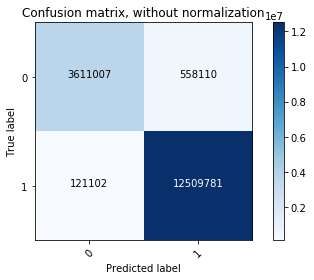

In [70]:
#fitting model
pred_y = m.predict(X_test)
    
#confusion matrix
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [73]:
#key Performance Metrics
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
F1 = 2 * (precision * recall) / (precision + recall)
print("precision:", precision*100)
print("recall:", recall*100)
print("false positive rate:", fpr*100)
print("accuracy",  accuracy*100)
print("F1-score", F1)

precision: 95.72915017427066
recall: 99.04122300871602
false positive rate: 13.386767509762858
accuracy 95.95707142857142
F1-score 0.9735702566978488


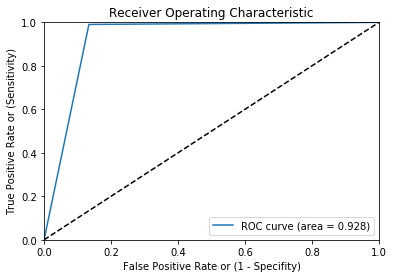

In [74]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 4.2 Gradient Boosting Classifier

In [ ]:
g = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=100, max_features=0.5, subsample = 0.9, random_state = 2, max_depth = 3)
g.fit(X_train, y_train) 
pred_y = g.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

/home/rk9cx/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix, without normalization
[[ 3542590   626527]
 [  127408 12503475]]


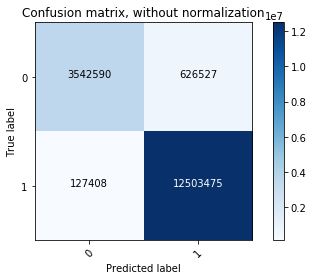

In [81]:
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [79]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
F1 = 2 * (precision * recall) / (precision + recall)
F1 = 2 * (precision * recall) / (precision + recall)
print("precision:", precision*100)
print("recall:", recall*100)
print("false positive rate:", fpr*100)
print("accuracy",  accuracy*100)
print("F1-score", F1)

precision: 95.22827947779444
recall: 98.99129775804273
false positive rate: 15.027810445233367
accuracy 95.51229166666667
F1-score 0.9707333424298117


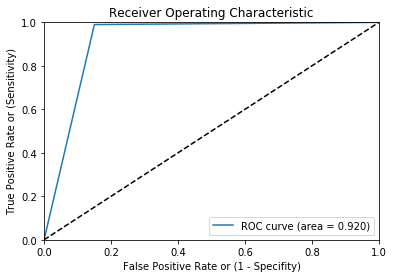

In [80]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 3.1 Random Forest

In [ ]:
def default_random_forest(X_train, y_train, X_test, y_test):
    
    #classifier
    m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
    m.fit(X_train, y_train) 
    pred_y = m.predict(X_test)
    
    #confusion matrix
    cm= confusion_matrix(y_test, pred_y)
    plt.figure()
    plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')
    
    #performance metrics calculation
    tn, fp, fn, tp = cm.ravel()
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    fpr = fp/(fp+ tn)
    accuracy = (tp + tn)/(tn + tp + fn + fp)
    F1 = 2 * (precision * recall) / (precision + recall)
    print("precision:" + precision*100))
    print("recall:", recall*100)
    print("false positive rate:", fpr*100)
    print("accuracy",  accuracy*100)
    print("F1-score", F1)
    
    #ROC Curve
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc

    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_test, pred_y)
    roc_auc = auc(fpr,tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return pred_y

## 3.3 Artificial Neural Network

In [115]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
       
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall(y_true, y_pred):
   
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
    

def precision(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [124]:
model = models.Sequential()
model.add(Dense(25, input_dim=53, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
sgd=optimizers.SGD(lr=0.001, momentum=0.5, decay=0.00002, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [126]:
result = model.fit(X_train, y_train, epochs=30, batch_size=256, verbose=1, validation_split=0.3) 

Train on 2370368 samples, validate on 1015872 samples
Epoch 1/30
2370368/2370368 [==============================] - 32s 14us/step - loss: 7.5679 - acc: 6.8344e-05 - val_loss: 8.9116 - val_acc: 0.0000e+00
Epoch 2/30
2370368/2370368 [==============================] - 33s 14us/step - loss: 7.5825 - acc: 0.0069 - val_loss: 8.9116 - val_acc: 0.0000e+00
Epoch 3/30
2370368/2370368 [==============================] - 33s 14us/step - loss: 7.5694 - acc: 7.4630e-04 - val_loss: 8.9116 - val_acc: 0.0000e+00
Epoch 4/30
2370368/2370368 [==============================] - 33s 14us/step - loss: 7.5693 - acc: 7.5220e-04 - val_loss: 8.9116 - val_acc: 0.0000e+00
Epoch 5/30
2370368/2370368 [==============================] - 32s 14us/step - loss: 7.5697 - acc: 7.3280e-04 - val_loss: 8.9116 - val_acc: 0.0000e+00
Epoch 6/30
2370368/2370368 [==============================] - 33s 14us/step - loss: 7.5691 - acc: 6.3408e-04 - val_loss: 8.9116 - val_acc: 0.0000e+00
Epoch 7/30
2370368/2370368 [======================

In [127]:
preds = model.predict_classes(X_test)

Confusion matrix, without normalization
[[      0       0]
 [1798911 1778461]]


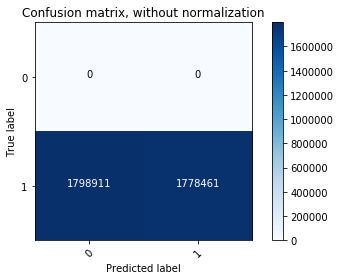

In [128]:
cm= confusion_matrix(preds, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [129]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
F1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, fpr*100, accuracy*100, F1)

1.0 0.4971417565743792 nan 49.71417565743792 0.664121155383299


/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [ ]:
import random
outliers_fraction = [0.5,0.4,0.3,0.20,.25,0.2,0.15,0.1,0.05,0.01,0.001]
n_estimators=[100,200,300]
max_features = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for i in range(10):
    a = random.choice(n_estimators)
    b = random.choice(max_features)
    c = random.choice(outliers_fraction)
    I = IsolationForest(n_estimators=a, max_features=b, contamination=c, n_jobs=-1)
    I.fit(X_train)
    X_train["Iscores"+ str(i)] = I.predict(X_train)
    X_train["Iscores"+ str(i)] = [1 if x == -1 else 0 for x in X_train["Iscores"+ str(i)]]
    I.fit(X_test)
    X_test["Iscores"+ str(i)] = I.predict(X_test)
    X_test["Iscores"+ str(i)] = [1 if x == -1 else 0 for x in X_test["Iscores"+ str(i)]]

/home/rk9cx/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/rk9cx/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/rk9cx/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/rk9cx/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 

In [ ]:
X_train_sep = X_train.T.tail(10).T
X_test_sep = X_test.T.tail(10).T

In [ ]:
RF = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, max_features=0.6).fit(X_train_sep, y_train)
pred_y=RF.predict(X_test_sep)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [ ]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)